In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [11]:
data = pd.read_csv('data/48_Industry_Portfolios.csv', skiprows=11, nrows=1181, index_col=0)
data.index = pd.to_datetime(data.index, format='%Y%m')
data = data[data.index >= pd.Timestamp('2019-11-01')]
data.head()

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
2019-11-01,-0.68,3.43,-0.18,-0.60,5.52,4.12,6.41,-0.79,-1.33,4.56,...,1.80,2.77,4.17,2.06,2.69,5.04,6.51,6.90,7.19,4.41
2019-12-01,11.14,3.06,3.97,1.39,3.22,-1.02,4.91,3.26,2.59,7.58,...,0.59,-0.22,2.44,1.21,2.27,3.25,2.21,5.58,0.79,1.73
2020-01-01,-3.31,-1.38,5.21,2.70,-3.66,-3.37,1.01,-4.34,0.39,-5.41,...,-0.97,-0.15,-2.99,1.14,1.50,-3.70,-2.86,-1.86,2.98,0.82
2020-02-01,-6.11,-9.30,-8.19,-7.47,-6.71,-17.11,-3.68,-6.65,-8.46,-9.54,...,-7.22,-10.89,-9.37,-6.03,-9.36,-11.49,-8.88,-10.05,-10.47,-8.43
2020-03-01,-11.12,-4.24,-15.44,-9.92,-6.76,-18.85,-16.29,-22.65,-6.75,-19.46,...,-9.69,-16.81,-17.82,-4.48,-22.12,-23.90,-12.74,-35.95,-16.86,-14.99


# Part A

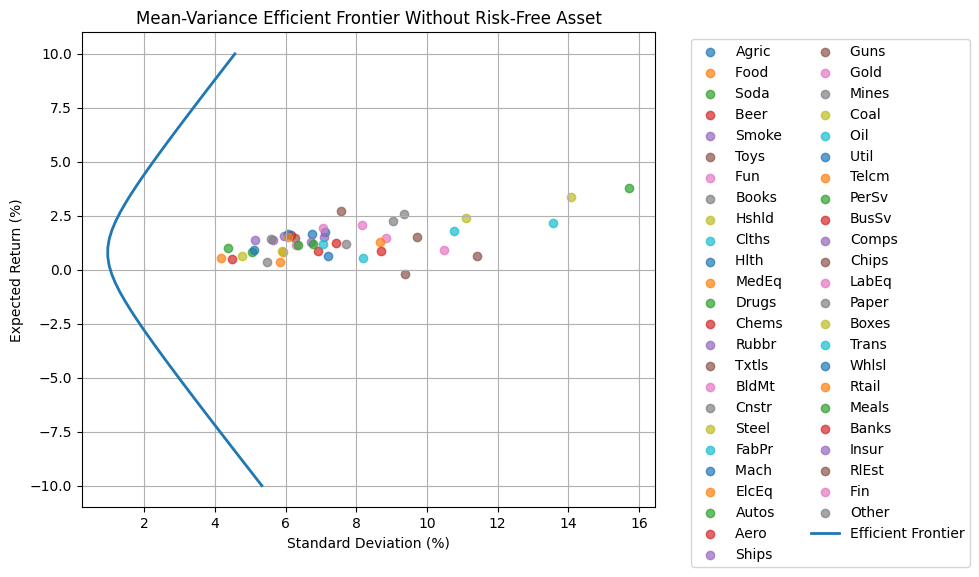

In [26]:
# Question 1
returns = data.mean().values
cov_matrix = data.cov().values
num_assets = len(returns)

def portfolio_variance(weights, cov_matrix):
    return 0.5 * weights.T @ cov_matrix @ weights

def constraint_sum_weights(weights):
    return np.sum(weights) - 1

def constraint_portfolio_return(weights, mu, returns):
    return returns.T @ weights - mu

expected_returns = np.linspace(-10, 10, 50)
efficient_portfolios = []

# find efficient frontier
for mu in expected_returns:
    # Constraints
    constraints = [
        {"type": "eq", "fun": constraint_sum_weights},
        {"type": "eq", "fun": lambda w, mu=mu: constraint_portfolio_return(w, mu, returns)},
    ]
    
    
    initial_weights = np.ones(num_assets) / num_assets
    
    bounds = [(None, None) for _ in range(num_assets)]
    
    result = minimize(
        portfolio_variance,  
        initial_weights, 
        args=(cov_matrix,),
        method="SLSQP",
        constraints=constraints,
        bounds=bounds,
    )
    
    if result.success:
        weights = result.x
        variance = portfolio_variance(weights, cov_matrix)
        efficient_portfolios.append((mu, variance))

# store efficient frontier in a dataframe
efficient_df = pd.DataFrame(efficient_portfolios, columns=["Return", "Variance"])

#plot efficient frontier
plt.figure(figsize=(10, 6))

for i, industry in enumerate(data.columns):
    industry_return = returns[i]
    industry_std = np.sqrt(cov_matrix[i, i])
    plt.scatter(industry_std, industry_return, label=industry, alpha=0.7)

# Plot the efficient frontier
plt.plot(
    np.sqrt(efficient_df["Variance"]),
    efficient_df["Return"], 
    marker="", 
    label="Efficient Frontier", 
    linewidth=2
)

plt.title("Mean-Variance Efficient Frontier Without Risk-Free Asset")
plt.xlabel("Standard Deviation (%)")
plt.ylabel("Expected Return (%)")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
plt.tight_layout()
plt.show()

/var/folders/c5/0k9q6ymj10d7tsm7thk3_yqr0000gn/T/ipykernel_34916/1881603320.py:63: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


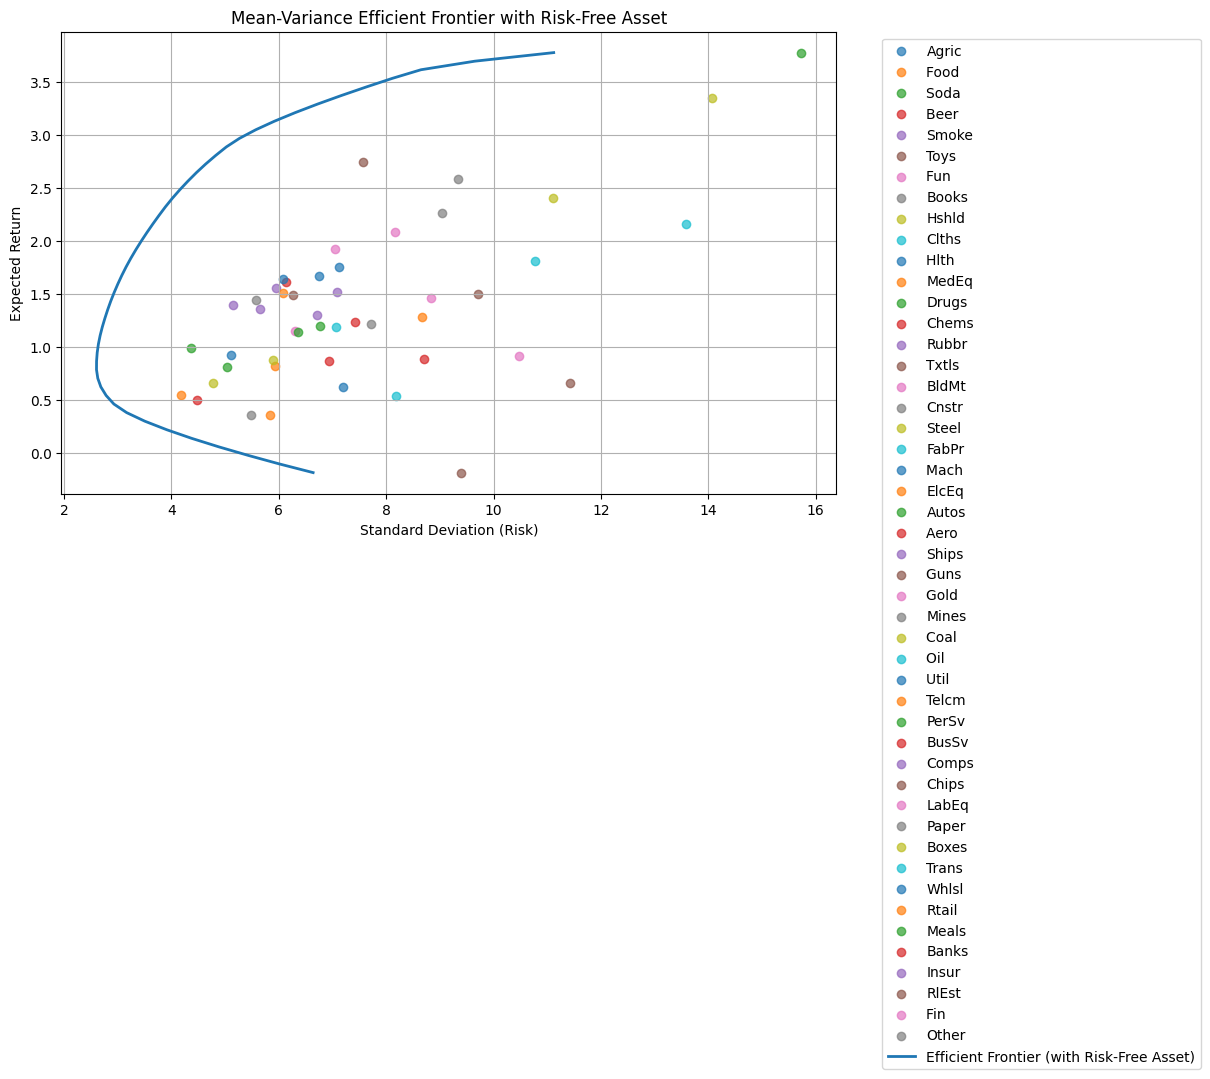

#### Mean-Variance Portfolio Problem
No risk free asset:
- Assume investors' preferences can be represented by a derived utility function $V(\hat{Z}, \sigma^2)$. The expected return and variance on the portfolio are
$$\bar{Z} = \textbf{w}'\bar{\textbf{z}}+w_0 R = \sum_{i=0}^N w_i\bar{z}_i$$
$$\sigma^2 = \textbf{w}'\mathbf{\Sigma}\textbf{w} = \sum_{i=1}^N\sum_{j=1}^N w_iw_j\sigma_{ij}$$
- First choose weights to minimize variance for a given return $\mu$:

$$\min \frac{1}{2} \mathbf{w}' \mathbf{\Sigma} \mathbf{w}$$

subject to:

$$\mathbf{1}'\mathbf{w} = 1$$

$$\bar{\mathbf{z}}' \mathbf{w} = \mu$$

With risk free asset:

$$\min \frac{1}{2} \mathbf{w}' \mathbf{\Sigma} \mathbf{w}$$

subject to:

$$(\bar{\mathbf{z}} - R\mathbf{1})'\mathbf{w} = \mu - R$$